## Introduction
In this notebook, we will perform anomaly detection on a dataset the examines the volume of tweet mentions received by Google in 5 minute intervals. This could be useful in the real world because Twitter is the first place customers go to complain. Therefore, if there are an unusually high number of mentions (without a major product launch or other big event), there could be an issue with the service that needs to be attended to immediately. Having an anomaly detection model could notice this pattern and alert the appropriate individuals.

### 1) Data Exploration and Cleaning

In [1]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/Twitter_volume_GOOG.csv", index_col=[0], parse_dates=[0])
print(original.head(5))

                     value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41
2015-02-26 21:52:53     32
2015-02-26 21:57:53     36
2015-02-26 22:02:53     32


In [2]:
original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15842 entries, 2015-02-26 21:42:53 to 2015-04-22 21:47:53
Data columns (total 1 columns):
value    15842 non-null int64
dtypes: int64(1)
memory usage: 247.5 KB


Notice that the timestamp column is not a datetime. We want to convert this to a datetime so we can group all of the tweets together by hour to get a consistent time period for comparison. The sum of each hour's tweets will become the value.

In [3]:
original = original.resample('H').sum()
original.head()

,value
timestamp,
2015-02-26 21:00:00,144
2015-02-26 22:00:00,365
2015-02-26 23:00:00,332
2015-02-27 00:00:00,581
2015-02-27 01:00:00,387


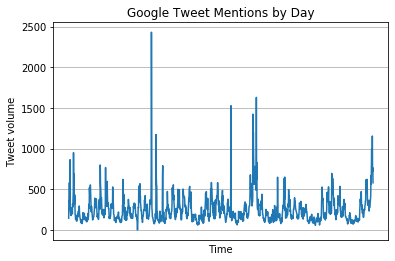

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
import datetime

fig, ax = plt.subplots()
ax.plot(original.index, original['value'])
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)


ax.set(xlabel='Time', ylabel='Tweet volume',
       title='Google Tweet Mentions by Day')
ax.grid()
plt.show()


We grouped the data by hour to simplify its graphical appearance and to create a timeframe that should be relatively consistent day to day, month to month. As can be seen in the graph, which graphs 3 months of data, there are several extreme outliers that would be considered anomalies. Additionally, there doesn't appear to be a trend that we need to consider over the course of the three months. 

### 2) Models and Results
Next we will generate models to predict them. There are not many features and we can even throw out the date, so as to solely focus on the tweet volume in both a stastical way and classification model. First, we will do an interquartile range. This is a quick statistical method that is an effective way to group data and is easy to understand.

In [5]:
q75, q25 = np.percentile(original['value'], [75 ,25])
iqr = q75 - q25
totalMedian = original['value'].median()
print('Median: ' + str(totalMedian))
print('Interquartile Range: ' + str(iqr))
print('Q25: ' + str(q25))
print('Q75: ' + str(q75))

Median: 200.0
Interquartile Range: 159.0
Q25: 144.0
Q75: 303.0


Now that we have the interquartile range, we can find the outliers by using the 1.5xIQR rule. The rule states that if a data point is more than 1.5 * IQR below the first quartile or above the third quartile, then it is an outlier. Let's calculate those threshholds below.

In [6]:
#low bound
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr
print('Low Outliers are below: ' + str(low))
print('High Outliers are above: ' + str(high))

count = original.count()
highCount = original[original['value'] > high].count()
print('Outliers to normal ratio: ' + str(highCount / count))

Low Outliers are below: -94.5
High Outliers are above: 541.5
Outliers to normal ratio: value    0.049962
dtype: float64


In [7]:
average1 = original[original['value'] < high]['value'].mean()

average2 = original[original['value'] >= high]['value'].mean()

print('Outlier Average:')
print(average2)
print('Normal Average:')
print(average1)
print('Outlier to Normal Average Ratio')
print(average2 / average1)

Outlier Average:
767.6818181818181
Normal Average:
221.38565737051792
Outlier to Normal Average Ratio
3.467622190614643


Since the low outliers are negative and we have no negative numbers in the dataset, only the high outlier number (48.5) is relevant. This means that if there are more than 541 tweets in an hour, we can claim this is an outlier and the content being tweeted about may need someone at Google to look into it. Observe, the ratio of the outlier to normal average is 3.46.

Below, we add yellow stars to the original graph of tweet quantity to denote outliers.

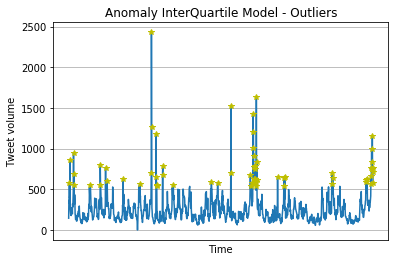

In [8]:
fig, ax = plt.subplots()
ax.plot(original.index, original['value'])
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set(xlabel='Time', ylabel='Tweet volume',
       title='Anomaly InterQuartile Model - Outliers')
ax.grid()
for i, row in original.iterrows():
    if (row['value'] >= high):
        ax.plot(i, original['value'][i], 'y*')
plt.show()


Next, lets train a clustering model to do the anomaly detection. We will generate two clusters, one which should represent the outliers and one which should represent the normal values. The KMeans algorithm is quick and fairly accurate on datasets with limited features, so it is a good choice here. To vocalize the obvious concept, most of the data should center around the mean, which represents the normal values, while outlier data, since it will likely only be upper outliers as a conclusion of the analysis above with the interquartile range, will cluster around a higher value.

In [9]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

x = original.as_matrix(columns=['value']).astype('int')

postCluster = original

kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(x)
postCluster['Cluster'] = kmeans
postCluster.head()

cluster1Count = postCluster['Cluster'][postCluster['Cluster'] ==0].count()
print('Outlier Count')
print(str(cluster1Count))
cluster2Count = postCluster['Cluster'][postCluster['Cluster'] ==1].count()
print('Normal Count')
print(str(cluster2Count))

print('Ratio')
print(str(cluster1Count / cluster2Count))

Outlier Count
182
Normal Count
1139
Ratio
0.15978928884986832


The result of the clustering algorithm shows that we have almost 16% of the data as an outlier, which isn't too far from the interquartile range's 5%. We can take the average of each cluster to show where the clusters are centered.

In [10]:
average1 = postCluster['value'][postCluster['Cluster'] ==0].mean()
average2 = postCluster['value'][postCluster['Cluster'] ==1].mean()

print('Outlier Average:')
print(average1)
print('Normal Average:')
print(average2)
print('Outlier to Normal Average Ratio')
print(average1 / average2)

Outlier Average:
563.0604395604396
Normal Average:
198.4451273046532
Outlier to Normal Average Ratio
2.837360872539987


Observe that the ratio here is 2.84, as opposed to nearly 3.5 in the interquartile range. This makes sense, since we have a higher outlier rate with the clustering model. All the additional outliers would come from lowering the upper bound (since we don't have low-end outliers), thus decreasing the outlier average. Of course, this also decreases the normal average, but not enough to offset the magnitude of the outlier average decrease.

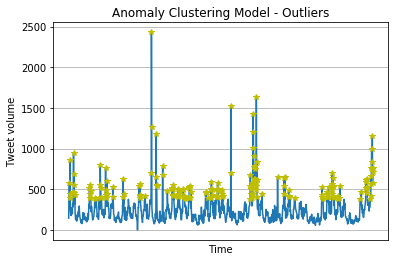

In [11]:
fig, ax = plt.subplots()
ax.plot(postCluster.index, postCluster['value'])
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set(xlabel='Time', ylabel='Tweet volume',
       title='Anomaly Clustering Model - Outliers')
ax.grid()
for i, row in postCluster.iterrows():
    if (row['Cluster'] == 0):
        ax.plot(i, postCluster['value'][i], 'y*')
plt.show()

In [12]:
#calculate lowest value classified as an outlier
postCluster0 = postCluster[postCluster['Cluster'] == 0]
print(postCluster0['value'].min())

381


As can be seen above, the graph looks similar to that of the Interquartile range. However, as the average outlier is lower, it is easy to reason that the threshold for an outlier is lower. In fact, the lowest value classified as an outlier is 381, compared to 542 on the interquartile range. As a result, the graph is more decorated with yellow stars.

### 3) Conclusion
The two methods we used to detect anomalies yielded differing results. Of course, we were using data which didn't have labels (anomaly or no-anomaly), which means that what is classified as an outlier is largely influenced by model parameters. For instance, we used 1.5 as the multiplciation constant in the IQR. Changing this would affect the outlier threshold. Likewise, we could modify how the anomaly classification algorithm was trained to alter the outcome. In some cases, it is useful to have multiple thresholds, for instance, if both thresholds are exceeded, then something might be highly urgent vs only somewhat urgent if only the lower threshold is exceeded. Extensions would be using other types of models such as random or isolation forest. However, since we were only using one feature, KMeans clustering appeared to work the best. Additionally, we could group by day or month to look at macro trends, potentially giving insight into the market's perception of the companies which could influence stock prices. Finally, if we had years of data, it would be insightful to consider constant fluctions on certain dates. Such as Google's developer conference every summer - this likely leads to an increase in tweets and thus is an expected anomaly, one which wouldn't be important to an anomaly detection system used for determining problems with a service. However, as said, we would need years, rather than months of data. 